# Analyze A/B Test Results 




<a id='intro'></a>
## Introduction

For this project, we are working to understand the results of an A/B test run by an e-commerce website.  Our goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability



In [2]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
random.seed(42)

%matplotlib inline

In [3]:
# read data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The number of rows in the dataset.

In [4]:
print(f'Number of rows in the dataset: {df.shape[0]} rows.')

Number of rows in the dataset: 294478 rows.


The number of unique users in the dataset.

In [5]:
print(f'number of unique users in the dataset: {df.user_id.nunique()} users.')

number of unique users in the dataset: 290584 users.


The proportion of users converted.

In [6]:
df.query('converted == 1').user_id.count() / df.user_id.count()

0.11965919355605512

In [7]:
# By other manner
df['converted'].mean()

0.11965919355605512

The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [8]:
wing1= df.query('landing_page=="new_page" & group!="treatment"').shape[0]
wing2= df.query('landing_page=="old_page" & group!="control"').shape[0]
wing1+wing2

3893

Check if there are missing values:

In [9]:
df.isnull().any(axis=1).sum()

0

>**No missing values.**

In [10]:
# Store only correct results in a new dataframe df2
df2 = df[(df.group=="treatment") == (df.landing_page=="new_page")]

In [11]:
# Double Check all of the incorrect rows were removed from df2 - 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]
# Output of the statement below equals to 0 - cool

0

Number of unique **user_id**s are in **df2**

In [12]:
df2.user_id.nunique()

290584

>**290584 unique users.**

In [13]:
df2.shape[0]

290585

Number of repeated user_id

In [14]:
repeated = df2.shape[0] - df2.user_id.nunique()
repeated

1

Faulty user_id

In [15]:
df2.user_id.mode()[0]

773192

Display the rows for the duplicate **user_id**

In [16]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [17]:
# Remove (row 1899)
df2 = df2.drop([1899],axis=0)

In [18]:
# Recheck again
df2.query('user_id == 773192')

# The row with a duplicate user_id was deleted.

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [19]:
repeated = df2.shape[0] - df2.user_id.nunique()
repeated

0



> $p_{population}$ : The probability that represents the overall "converted" success rate in the population.



In [20]:
P_population= df2.query('converted==1').shape[0]/ df2.shape[0]
P_population

0.11959708724499628

Given that an individual was in the `control` group, the probability they converted calculated as:

In [21]:
# control df
control_df = df2.query('group=="control"')

In [22]:
p_old = control_df.query('converted==1').shape[0]/ \
                        control_df.shape[0]

p_old                       

0.1203863045004612

Given that an individual was in the `treatment` group, the probability they converted calculated as:

In [23]:
# treatment df
treatment_df = df2.query('group=="treatment"')

In [24]:
p_new = treatment_df.query('converted==1').user_id.nunique()/ \
                        treatment_df.user_id.nunique()

p_new

0.11880806551510564

Now, calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups.

In [25]:
obs_diff = p_new - p_old
obs_diff

-0.0015782389853555567

The probability that an individual received the new page:

In [26]:
df2.query('landing_page=="new_page"').shape[0] / \
    df2.shape[0]
    

0.5000619442226688

>**It seems that the conversion rate for old page group `(P_old)` is `slightly higher` than the conversion rate for new page group `(P_new)`, but we can't do a fair decision depending only this difference yet!**

<a id='ab_test'></a>
## Part II - A/B Test

> State our hypothesis:

$H_0:$  

**$p_{old}$** >= **$p_{new}$**

or
  
**$p_{new}$** - **$p_{old}$** <= 0

---

$H_1:$

**$p_{new}$** > **$p_{old}$**

or


**$p_{new}$** - **$p_{old}$** > 0

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br>

$p_{new}$ = $p_{old}$ = $p_{population}$

In [27]:
# The **conversion rate** for p_new under the null hypothesis
p_new = P_population
p_new

0.11959708724499628

In [28]:
# The **conversion rate** for p_old under the null hypothesis
p_old = P_population
p_old

0.11959708724499628

In [29]:
# the number of individuals in the treatment group
n_new=treatment_df.shape[0]
n_new

145310

In [30]:
# the number of individuals in the control group
n_old =control_df.shape[0]
n_old

145274

In [31]:
# Simulate a Sample for the treatment Group
import copy
treatment_copy = copy.deepcopy(treatment_df)
treatment_copy.loc[: ,'new_page_converted']= np.random.choice\
    ([0, 1],size=n_new, p=(1-P_population,P_population), replace=True)

In [32]:
treatment_copy.head()

,user_id,timestamp,group,landing_page,converted,new_page_converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,0
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,0


In [33]:
treatment_copy.new_page_converted.value_counts()

0    128042
1     17268
Name: new_page_converted, dtype: int64

In [34]:
P_sample_new = treatment_copy.query('new_page_converted == 1').shape[0] / \
    treatment_copy.shape[0]

P_sample_new

0.11883559287041498

In [35]:
# Simulate a Sample for the control Group
import copy
control_copy = copy.deepcopy(control_df)
control_copy['old_page_converted'] = np.random.choice\
    ([0, 1],size=n_old, p=(1-P_population,P_population), replace=True)

In [36]:
control_copy.head()

,user_id,timestamp,group,landing_page,converted,old_page_converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,0


In [37]:
control_copy.old_page_converted.value_counts()

0    127833
1     17441
Name: old_page_converted, dtype: int64

In [38]:
P_sample_old = control_copy.query('old_page_converted == 1').shape[0] / \
    control_copy.shape[0]

P_sample_old

0.12005589437889781

In [39]:
# difference in the "converted" probability
P_sample_new - P_sample_old

-0.0012203015084828323

In [40]:
treatment_df.shape[0] , control_df.shape[0] , n_new, n_old

(145310, 145274, 145310, 145274)

In [40]:
# Sampling distribution 
p_diffs = []
for _ in range(10000):
    treatment_df = df2.query('group=="treatment"')
    control_df = df2.query('group=="control"')
    treatment_copy = copy.deepcopy(treatment_df)
    control_copy = copy.deepcopy(control_df)
    treatment_copy['new_page_converted']= np.random.choice\
        ([0, 1],size=n_new, p=(1-P_population,P_population), replace=True)
    control_copy['old_page_converted'] = np.random.choice\
        ([0, 1],size=n_old, p=(1-P_population,P_population), replace=True)
    P_sample_new = treatment_copy.query('new_page_converted == 1').shape[0] / \
                treatment_copy.shape[0]
    P_sample_old = control_copy.query('old_page_converted == 1').shape[0] / \
                control_copy.shape[0]
    
    p_diffs.append( P_sample_new - P_sample_old )

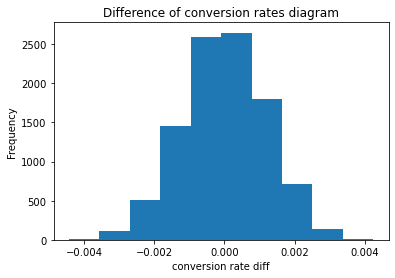

In [41]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.xlabel('conversion rate diff')
plt.ylabel('Frequency')
plt.title('Difference of conversion rates diagram')
plt.show();

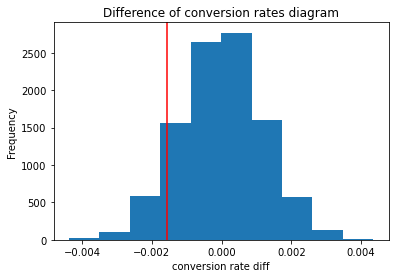

In [42]:
# make mean equals zero
null_val = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_val);
plt.axvline(x=obs_diff, color='r')
plt.xlabel('conversion rate diff')
plt.ylabel('Frequency')
plt.title('Difference of conversion rates diagram')
plt.show();

In [43]:
# P-value
( null_val > obs_diff ).mean()

0.9071

>**The calculated valued is called the p-value.**
**Because `P-value=0.9071` > $\alpha$ (Type I error)=0.05**<br>
**We failed to reject the null hypothesis (old page conversion rate**
**is better than or equal _at least_ the conversion rate of the new page).**



**Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.

In [41]:

# number of conversions with the old_page
convert_old = control_df.query('converted==1').shape[0]
print(convert_old)
# number of conversions with the new_page
convert_new = treatment_df.query('converted==1').shape[0]
print(convert_new)
# number of individuals who were shown the old_page
n_old = control_df.shape[0]
print(n_old)
# number of individuals who received new_page
n_new = treatment_df.shape[0]
print(n_new)


17489
17264
145274
145310


>Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.

- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group

In [42]:
import statsmodels.api as sm
count_array = np.array([convert_new,convert_old])
nobs_array = np.array([n_new,n_old])
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
print(p_value)

0.9050583127590245


>**We got almost the same p-value that we got in the previous hypothesis testing ( 0.905 )**

>**That means we faild again to reject the null hypothesis and we can't use treatment page instead of control page**

<a id='regression'></a>
### Part III - A regression approach

>**Because response variable is categorical one with only two possible output, so we should use `Logistic Regression`**

**I**<br> **Add an effect based only on the page.**

In [43]:
# ab_page - It's a dummy variable column, having a value `1` 
# when an individual receives the treatment
df2[['control','ab_page']]=pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [44]:
from statsmodels.formula.api import logit

# instantiate
log_model = logit("converted ~ ab_page", data=df2)
# fit
result = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [45]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-02-22 06:52 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

>**The p-value associated with `ab_page`** is **`0.1899`** **and it is greater than $\alpha$ (0.05)**
 
>**So again we can't reject the null hypothesis and should keep the control old page.**

>**It is a good idea to consider other factors to add into our regression model,**
>>because adding a new relevant variable can **`prevent bias`** in the estimate of the other regression coefficient,
>>but can also increase variance of other regression coefficient!

**II**<br> **Add an effect based on which country a user lives in.**

In [46]:
# Read the countries.csv
country_df = pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [47]:
# Join with the df2 dataframe
df_merged = pd.merge(df2,country_df, on = 'user_id', how = 'inner')

df_merged.head()

,user_id,timestamp,group,landing_page,converted,control,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [48]:
df_merged.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [49]:
# Create the necessary dummy variables
df_merged[['CA','UK','US']] = pd.get_dummies(df_merged['country'])

df_merged

,user_id,timestamp,group,landing_page,converted,control,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,US,0,0,1
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,US,0,0,1
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,US,0,0,1
290582,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,US,0,0,1


In [50]:
# Drop CA, fit our model, and summarize the results
log_model_2 = logit("converted ~ ab_page+US+UK", data=df_merged)
model_result = log_model_2.fit()
model_result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-02-22 06:53 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

>**P-value in all of our variables (ab_page &harr; 0.1912, US &harr; 0.1295, and UK &harr; 0.0745) is greater than $\alpha$ (=0.05)**<br>
which means that the null, for a regression model, that the coefficients
are equal to zero, cannot be rejected. So those variables, statistically, have
no effect on conversions.

**III**<br> **Add the effect based on `interaction between page and country a user lives in`.**
>> Adding interaction terms to a regression model has real benefits.<br> It greatly expands our understanding of the relationships among the variables in the model.

In [51]:
df_merged['US_inter'] = df_merged['US']*df_merged['ab_page']
df_merged['UK_inter'] = df_merged['UK']*df_merged['ab_page']

df_merged

,user_id,timestamp,group,landing_page,converted,control,ab_page,country,CA,UK,US,US_inter,UK_inter
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1,US,0,0,1,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1,US,0,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
290579,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0,US,0,0,1,0,0
290580,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0,US,0,0,1,0,0
290581,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0,US,0,0,1,0,0
290582,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0,US,0,0,1,0,0


In [52]:
log_model_3 = logit ("converted ~ ab_page+US+UK+US_inter+UK_inter", data=df_merged)
fit_result = log_model_3.fit()
fit_result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-02-22 06:57 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US_inter       0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_inter       0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

>**P-value in all of our variables (ab_page &harr; 0.1947 , US &harr; 0.6418, UK &harr; 0.7674, US_inter &harr; 0.3833, and UK_inter &harr; 0.1681)**<br> **is greater than $\alpha$ (=0.05)**<br>
which means that the null, for a regression model, that the coefficients
are equal to zero, cannot be rejected. So those variables, statistically, have
no effect on conversions.

## Conclusion

>**Based on the results of all our tests ( Hypothesis testing, Z-test, and Logistic Regression models)<br> 
We can conclude that the newer treatment page cannot be selected over the old control page.<br>
And we should keep using the old control page refer to our metric (conversion rate).**